# MODEL CODE - UNIDIRECTIONAL RNN WITH LSTM CELLS

### Removing unwanted data

SECTION BELOW IS DONE BY HELENA AND DOES NOT NEED TO BE RUN.

In [ ]:
def remove_unwanted_data(filename_in='', filename_out='',  invalid=True, duplicates=True, salts=True, stereochem=True, canonicalize=True):
    """Pre-processing of SMILES based on the user-defined parameters
            :param filename_in     path to the file containing the SMILES to pretreat (SMILES only) -- default = ChEMBL
            :param filename_out    path for file export -- default = ../data/
            :param invalid         if True (default), removes invalid SMILES
            :param duplicates      if True (default), removes duplicates
            :param salts           if True (default), removes salts
            :param stereochem      if True (default), removes stereochemistry
            :param canonicalize    if True (default), produces canonical SMILES
    """

    from preprocessor import Preprocessor
    p = Preprocessor(filename_in)

    print(Fore.GREEN + 'Pre-processing of "' + filename_in + '" started.')


    # user-defined pretreatment
    if invalid:
        p.remove_not_valid()
        print(Fore.GREEN + ' invalid SMILES - removed.')
        print(Style.RESET_ALL)

    if duplicates:
        p.remove_duplicates()
        print(Fore.GREEN + ' duplicate SMILES - removed.')
        print(Style.RESET_ALL)

    if salts:
        p.remove_salts()
        print(Fore.GREEN + ' salts - removed.')
        print(Style.RESET_ALL)

    if stereochem:
        p.remove_stereochem()
        print(Fore.GREEN + ' stereochemistry - removed.')
        print(Style.RESET_ALL)

    if canonicalize:
        p.canonicalize()
        print(Fore.GREEN + ' canonicalized SMILES.')
        print(Style.RESET_ALL)

    #save data to file
    p.save_data(filename_out)

    data = p.get_data()
    print(data[:5])


#remove_unwanted_data(filename_in='ChEMBL', filename_out='preprocessed_data.csv')
#data_no_descriptors=pd.read_csv('preprocessed_data.csv')

### Importing packages 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from rdkit import Chem
from rdkit.Chem import Descriptors

import os

from collections import OrderedDict
from itertools import chain
from sklearn.utils import shuffle


from colorama import Fore, Style
import matplotlib.pyplot as plt
import seaborn as sns

### Loading in preprocessed data & removing salts

STEP 1: This section of code loads in the seperate preprocessed data sections and makes one panda dataframe. 

In [2]:
csv_directory = 'D:\School\OGO Computational Biology\Data'

csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

dataframes = []

for csv_file in csv_files:
    file_path = os.path.join(csv_directory, csv_file)
    df = pd.read_csv(file_path, header=None)
    dataframes.append(df)

pp_data = pd.concat(dataframes, ignore_index=True)
pp_data.columns = ['canonical_smiles']
pp_data.drop_duplicates(subset='canonical_smiles', inplace=True) #removing duplicate SMILES. (as it was not done by Helena, due to error)

In [3]:
print(pp_data) #when you want to iterate through SMILES recall as pp_data["canonical_smiles"]

                                          canonical_smiles
0                             Cc1cc(-c2csc(N=C(N)N)n2)cn1C
1        CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)...
2        CCCCC1NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(C...
3        CC(C)CC1NC(=O)CNC(=O)C(c2ccc(O)cc2)NC(=O)C(C(C...
4                   Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1
...                                                    ...
2299991           O=S(=O)(CCC(F)(F)F)N1C2CCC1CC(n1cccn1)C2
2299992            CCOCC(=O)N1CCC(C(=O)N2CC(c3nccs3)C2)CC1
2299993  Cc1ccccc1CN1C(=O)c2ccccc2Sc2ccc(C(=O)NCCN3CCOC...
2299994  COc1cccc(N2CCN(C(=O)C3C4C=CC5(CN(Cc6ccccc6Cl)C...
2299995     Cc1ccc(S(=O)(=O)Cn2nnnc2CN2CCCC3(CCCCC3)C2)cc1

[2107759 rows x 1 columns]


STEP 2: We search for all two letter valid chemical elements within the dataset. Br and Cl are replaced with Z character. If another chemically valid element is found, we remove the whole string from the dataset.

In [4]:
smiles = pp_data['canonical_smiles'].tolist()
len(smiles)

2107759

In [5]:
from functions import data_filtering

new_smiles = data_filtering(smiles)

In [6]:
len(new_smiles[0])

2102184

In [7]:
filtered_data = new_smiles[0]

In [8]:
deleted_elements = new_smiles[1]

### Visualising random structures in ChEMBL.

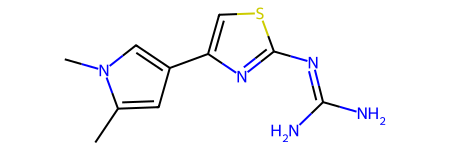

In [9]:
Chem.MolFromSmiles(filtered_data[0])

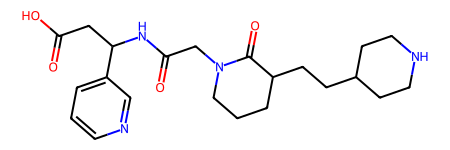

In [10]:
Chem.MolFromSmiles(filtered_data[50000])

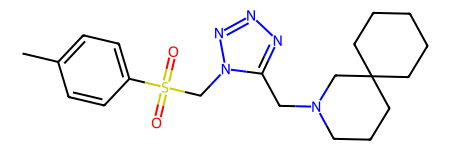

In [11]:
Chem.MolFromSmiles(filtered_data[2102183])

### Creating dictionary from preprocessed data

_adapted_data = chEMBL data with "Z" character._

_deleted_elements = valid chemical elements that are replaced in ChEMBL by Z._

STEP 2: dictionaries are made to map every unique character within preprocessed ChEMBL dataset with integer. Every detected unique character is checked on chemical validity. 

In [12]:
from functions import create_dictionary

dictionaries = create_dictionary(filtered_data)
char_to_int = dictionaries[0]
int_to_char = dictionaries[1]

In [13]:
char_to_int

{'(': 0,
 'F': 1,
 ']': 2,
 '+': 3,
 'O': 4,
 'S': 5,
 'B': 6,
 'C': 7,
 'b': 8,
 '0': 9,
 's': 10,
 '8': 11,
 '3': 12,
 'K': 13,
 'c': 14,
 ')': 15,
 'p': 16,
 'H': 17,
 'N': 18,
 '%': 19,
 '-': 20,
 '7': 21,
 'o': 22,
 'n': 23,
 '5': 24,
 '1': 25,
 '[': 26,
 '#': 27,
 '2': 28,
 '=': 29,
 '4': 30,
 '9': 31,
 'P': 32,
 'I': 33,
 '6': 34,
 'E': 35,
 'G': 36,
 'Z': 37}

In [14]:
int_to_char

{0: '(',
 1: 'F',
 2: ']',
 3: '+',
 4: 'O',
 5: 'S',
 6: 'B',
 7: 'C',
 8: 'b',
 9: '0',
 10: 's',
 11: '8',
 12: '3',
 13: 'K',
 14: 'c',
 15: ')',
 16: 'p',
 17: 'H',
 18: 'N',
 19: '%',
 20: '-',
 21: '7',
 22: 'o',
 23: 'n',
 24: '5',
 25: '1',
 26: '[',
 27: '#',
 28: '2',
 29: '=',
 30: '4',
 31: '9',
 32: 'P',
 33: 'I',
 34: '6',
 35: 'E',
 36: 'G',
 37: 'Z'}

###  Deviding data into subsets

Method is from Skinnider paper, but adapted.

STEP 1: determining how many sample_sizes we want to research

In [15]:
from functions import subset_splitting
sample_sizes=[1000,2500,5000,7500,10000,20000, 30000]

In [16]:
sample_sizes

[1000, 2500, 5000, 7500, 10000, 20000, 30000]

STEP 2: dictionary is created with _key_ as subset size and _value_ the subset which is randomly sampled from preprocessed ChEMBL data. 

In [17]:
from functions import subset_creation
subset_dict=subset_creation(smiles_list=filtered_data, sample_sizes=sample_sizes)

In [18]:
subset_dict.items()


dict_items([(1000,                                           canonical_smiles
1692743  COc1ccccc1NN=C(c1cc(OC)c(OC)c(OC)c1)c1nc(-c2cc...
110268                           CCc1ccccc1Nc1cc(O)nc(O)n1
732180   Cc1oc(-c2ccc(C(=O)NCCN(C)C)cc2)nc1CS(=O)(=O)c1...
1570006  CCOC(=O)C1=C(C)OC(N)=C(C#N)C1c1ccc(OCc2ccc(C)c...
2003274                 COc1cc(NC(=O)N(C)C(C)Cc2ccsc2)ncn1
...                                                    ...
1324070  COCCNc1cc(-c2nccc3c(-n4cnc(-c5cnn(C)c5)c4)cccc...
1658987                  Fc1cccc(Nc2nnc(-c3cccc(Z)c3)s2)c1
1548459          CC(C)c1ccc2c(c1)C(c1ccc(Z)cc1)C(C(=O)O)O2
1593445  CCOC(=O)C1CSC(c2ccccc2)N1C(=O)c1cn(CCc2ccc(F)c...
1661793    COc1cc(N)c(Z)cc1C(=O)OCCN1CCC(CNC(=O)CC(C)C)CC1

[1000 rows x 1 columns]), (2500,                                           canonical_smiles
1692743  COc1ccccc1NN=C(c1cc(OC)c(OC)c(OC)c1)c1nc(-c2cc...
110268                           CCc1ccccc1Nc1cc(O)nc(O)n1
732180   Cc1oc(-c2ccc(C(=O)NCCN(C)C)cc2)nc1CS(=O)(=O)c1...
157

### Lipinski descriptor distributions for created subset

[19:02:00] SMILES Parse Error: syntax error while parsing: COc1ccccc1NN=C(c1cc(OC)c(OC)c(OC)c1)c1nc(-c2ccc(Z)cc2)n[nH]c1=O
[19:02:00] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1NN=C(c1cc(OC)c(OC)c(OC)c1)c1nc(-c2ccc(Z)cc2)n[nH]c1=O' for input: 'COc1ccccc1NN=C(c1cc(OC)c(OC)c(OC)c1)c1nc(-c2ccc(Z)cc2)n[nH]c1=O'
[19:02:00] SMILES Parse Error: syntax error while parsing: NC(=O)c1cc(-c2ccc3c(c2)CCCN3C(=O)c2c(F)cccc2Z)c(Z)cc1F
[19:02:00] SMILES Parse Error: Failed parsing SMILES 'NC(=O)c1cc(-c2ccc3c(c2)CCCN3C(=O)c2c(F)cccc2Z)c(Z)cc1F' for input: 'NC(=O)c1cc(-c2ccc3c(c2)CCCN3C(=O)c2c(F)cccc2Z)c(Z)cc1F'
[19:02:00] SMILES Parse Error: syntax error while parsing: O=C(NCCN1CCOCC1)c1ccc(Z)c([N+](=O)[O-])c1
[19:02:00] SMILES Parse Error: Failed parsing SMILES 'O=C(NCCN1CCOCC1)c1ccc(Z)c([N+](=O)[O-])c1' for input: 'O=C(NCCN1CCOCC1)c1ccc(Z)c([N+](=O)[O-])c1'
[19:02:00] SMILES Parse Error: syntax error while parsing: Fc1ccc(-c2csc(NN=C(Cn3nnc4ccccc43)c3ccc(Z)cc3)n2)cc1
[19:02:00] SMILES Parse 

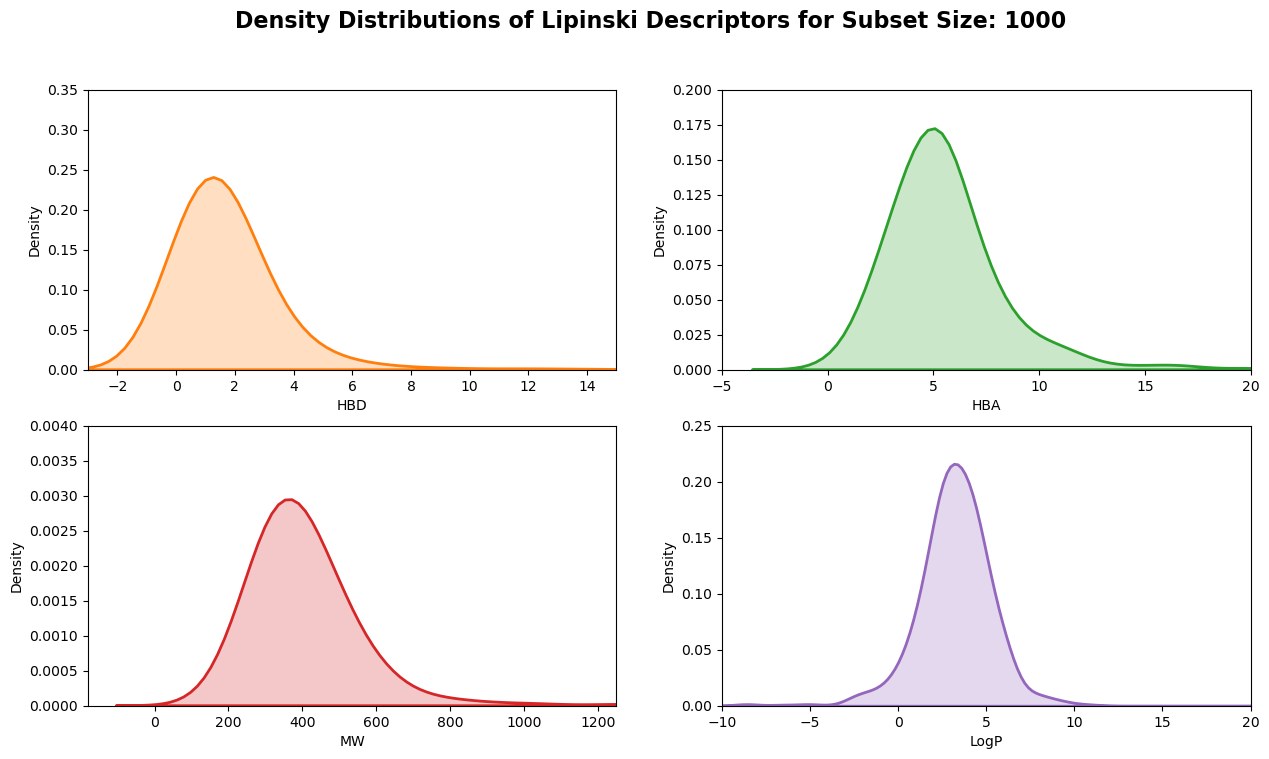

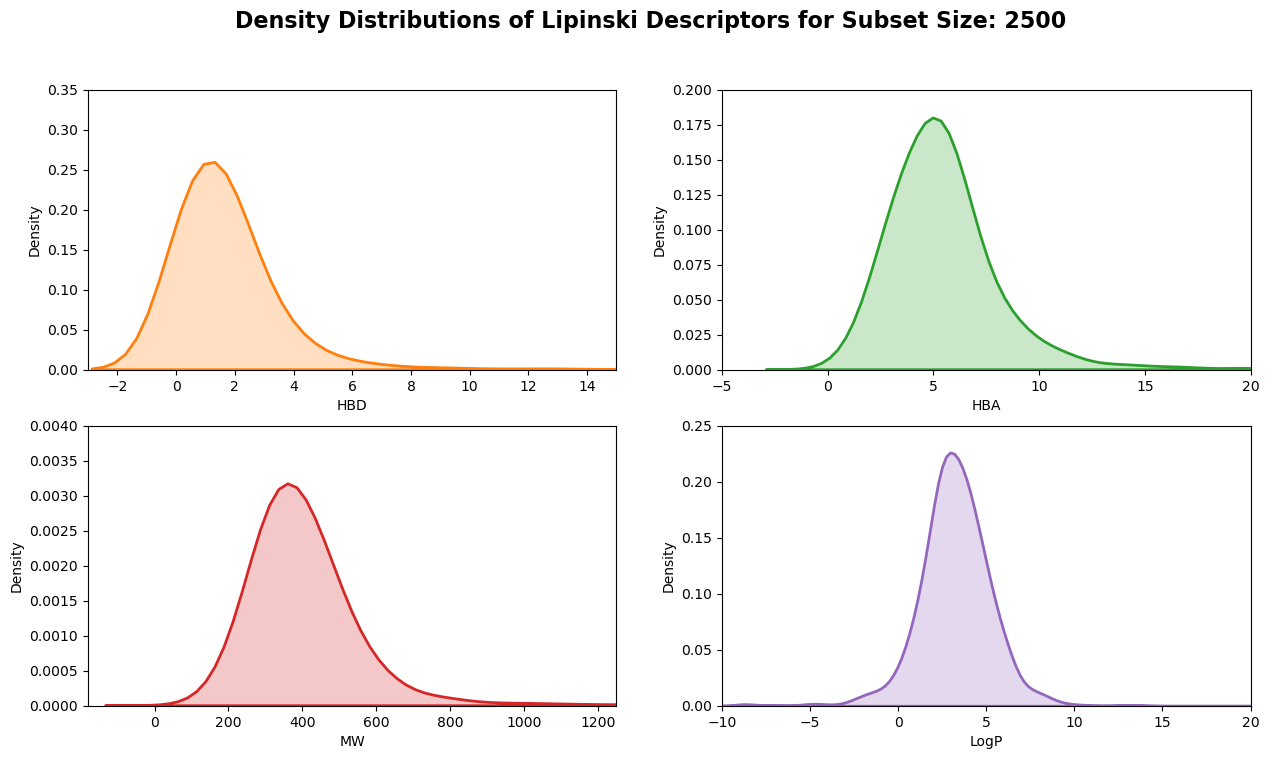

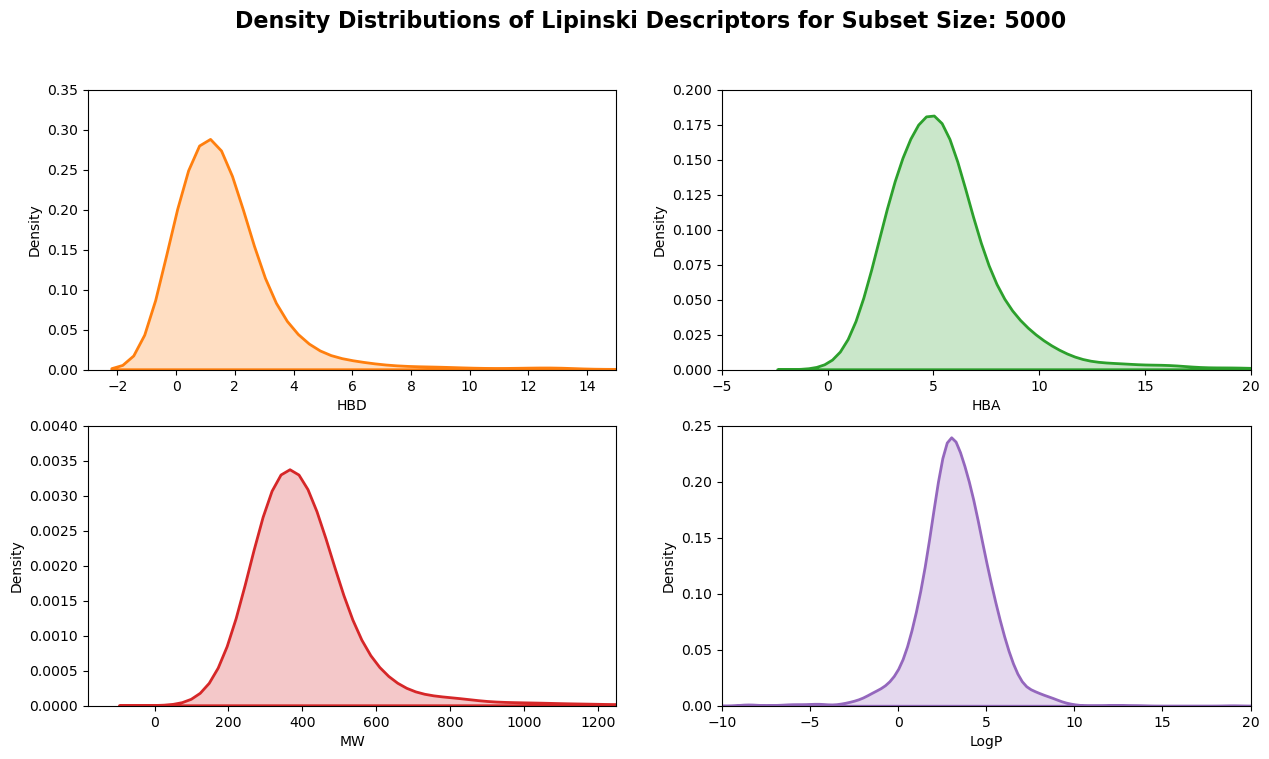

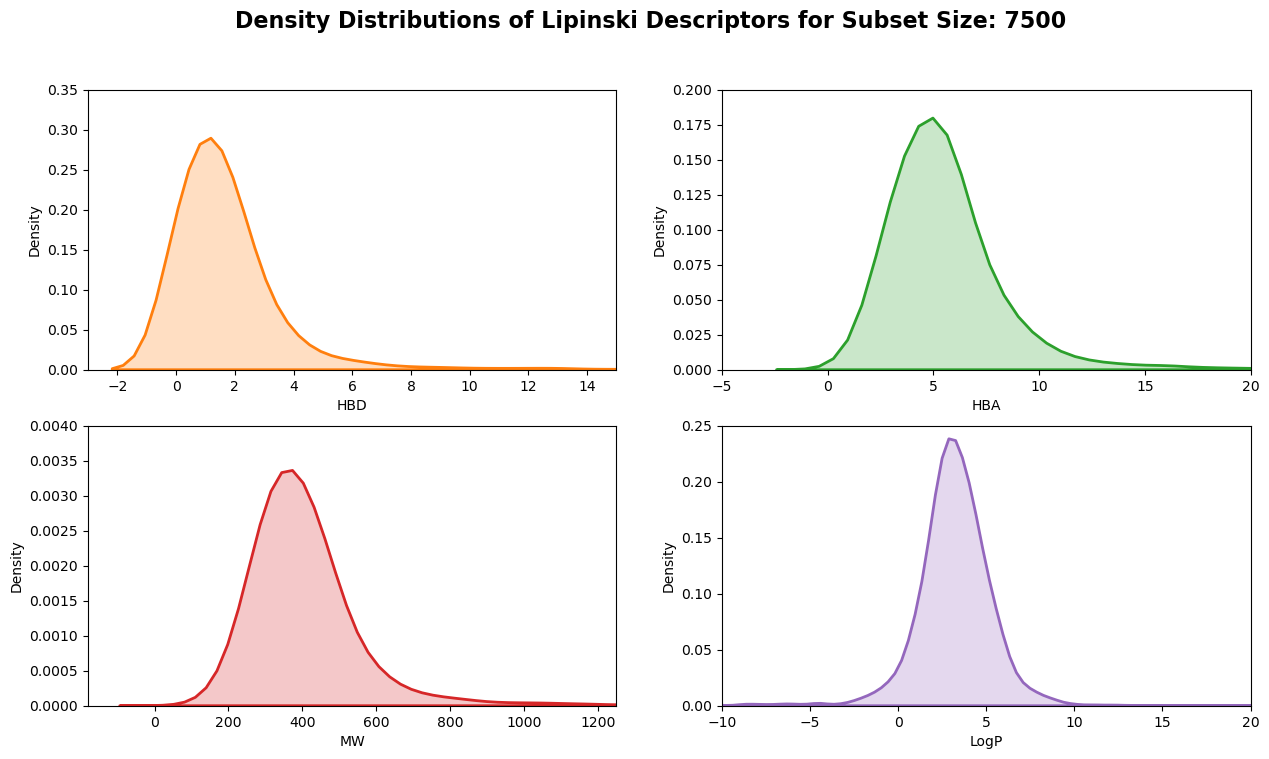

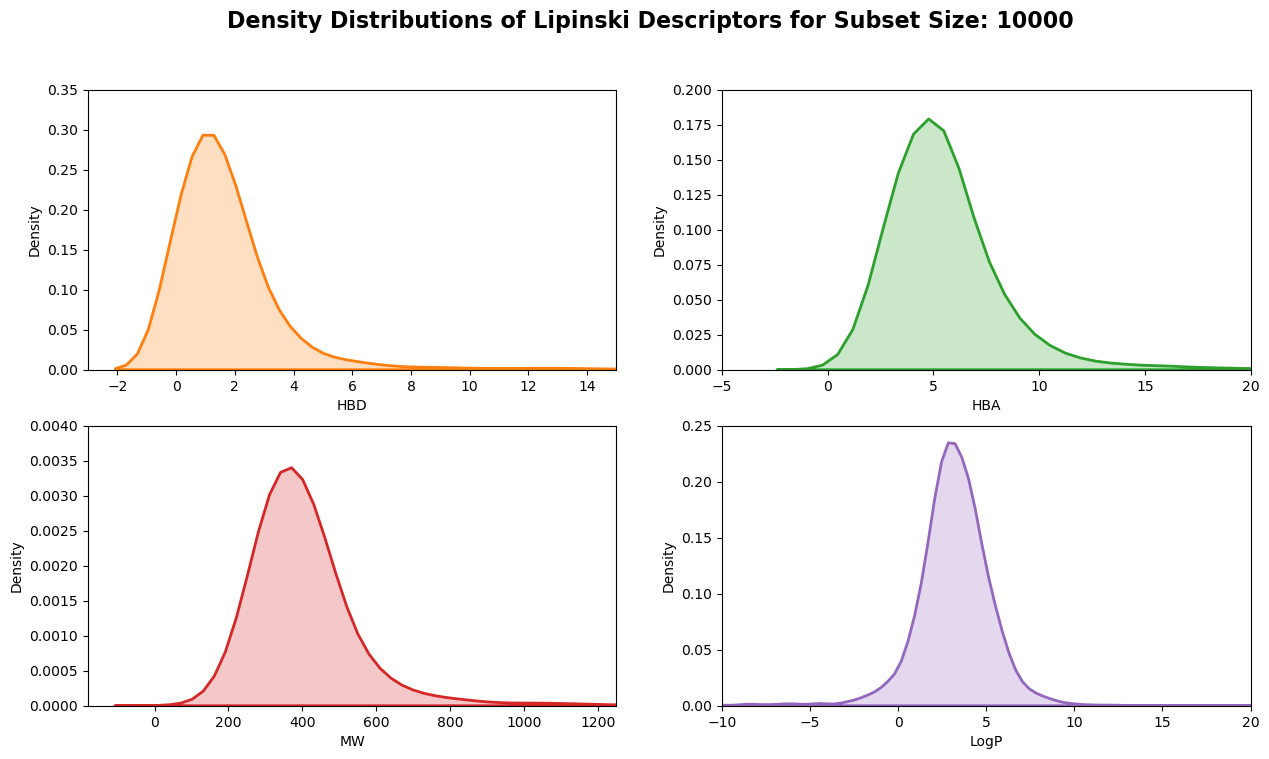

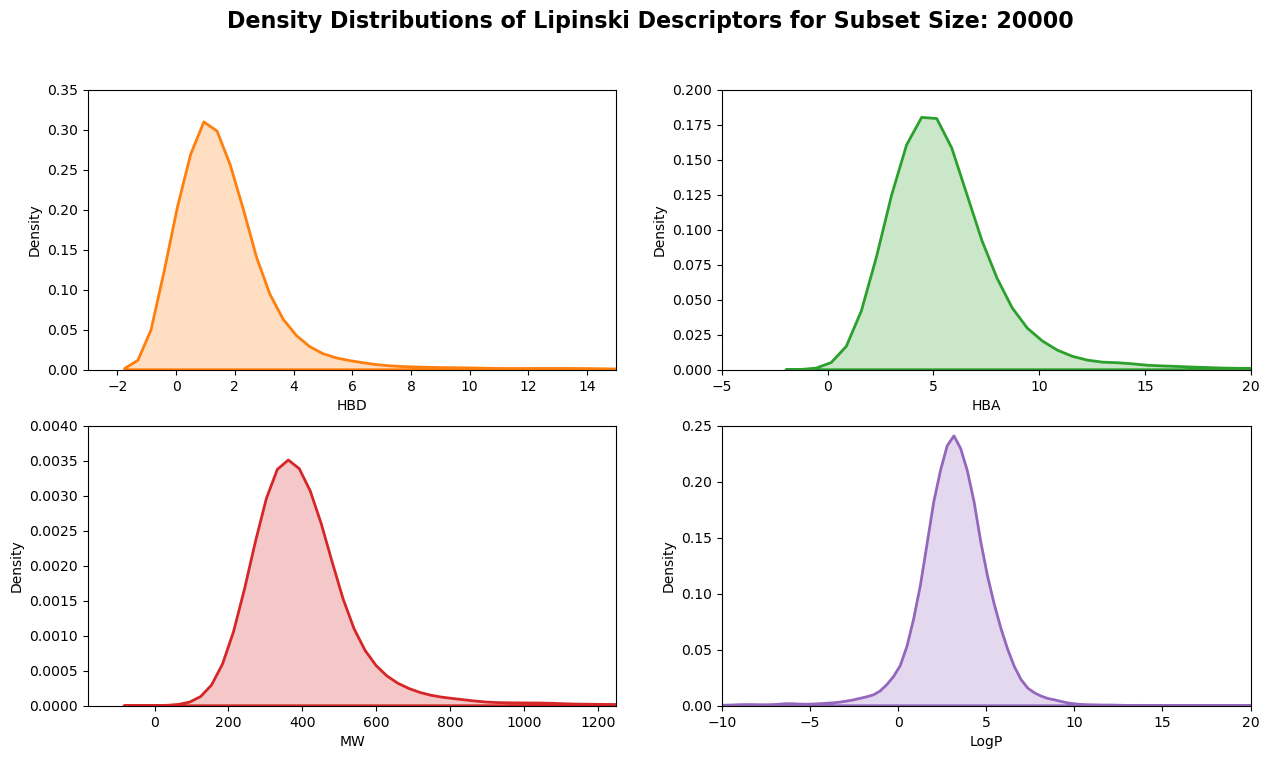

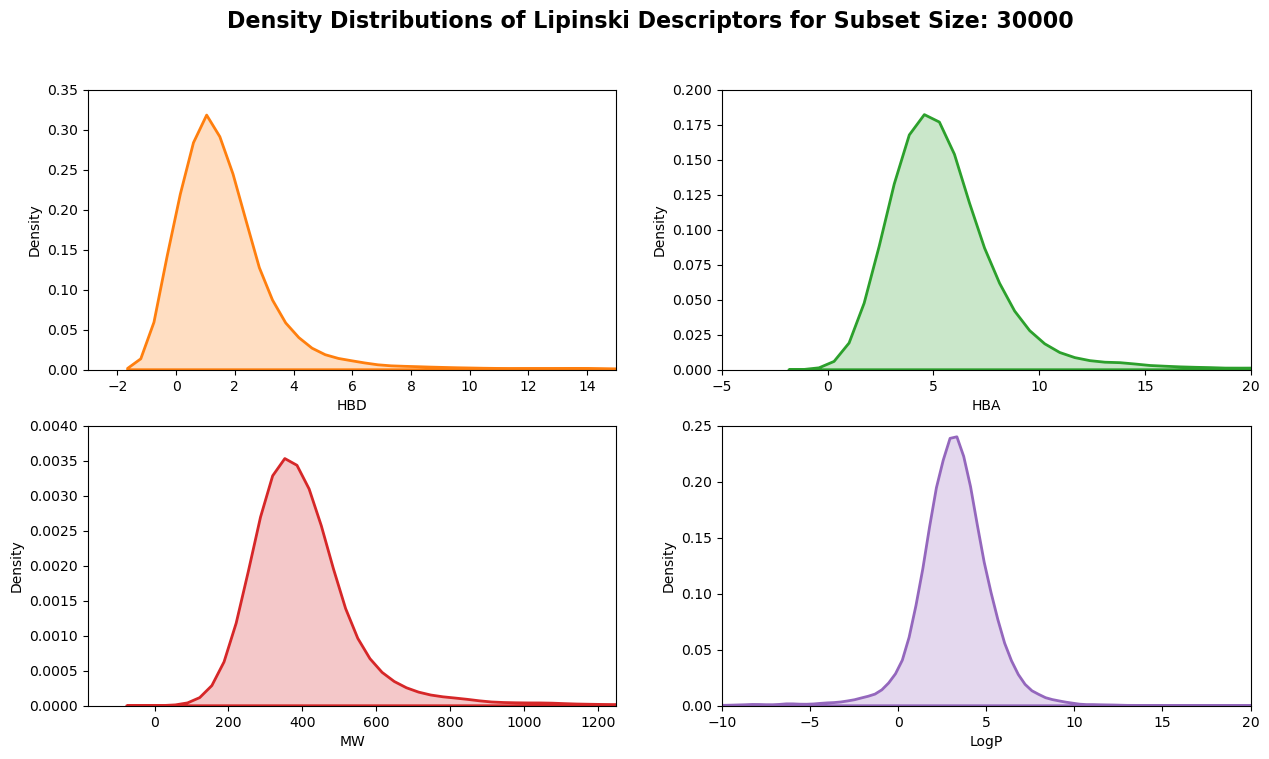

In [19]:
from functions import visualisation_distributions
import matplotlib.pyplot as plt
    
for key, value in subset_dict.items():
    output_filename = f'subset_{key}descr.csv'
    visualisation_distributions(data=value, output_filename=output_filename, subset_size=key)

### One-hot encoding

The encoder makes a 3D Numpy array which contains 2D one-hot encoded representations of the SMILES. This representation encodes each character in one-hot representation and adds 'endchar' symbol. It then returns two arrays; one for input sequence and the other for corresponding output.

*subsets possible = [50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000]*

In [ ]:
from functions import encoder

#define which subset you want to train with
subset = 5000

#generate arrays for training
X, Y = encoder(data=subset_dict[subset]['canonical_smiles'], encode=char_to_int)

X, Y = shuffle(X, Y) #shuffled for randomization

### RNN model with LSTM cells

Model is built with two LSTM layers with dropout for sequence processing. Batch normalization is applied to input and intermediate layers to enhance training stability. We also use a softmax activation function in the output layer. The model structure is mimicked to be like that of the MORET PAPER.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

model = Sequential()

#batch normalization for input data normalization
model.add(BatchNormalization(input_shape=(None, X.shape[2])))

model.add(LSTM(1024, return_sequences = True))
model.add(Dropout(0.25)) #to prevent overfitting

model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))

#normalization for regularization
model.add(BatchNormalization())

#Dense layer with softmax activation for output prediction
model.add(Dense(Y.shape[-1], activation='softmax'))

print (model.summary())

We then compile model using cross-entropy as loss function with Adam optimizer with learning rate of 0.001. 

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

#set parameters
learning_rate = 0.001

#Adam optimizer is used as it is popular for optimizing neural networks. 
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

We then train the model and employ Early stopping to monitor trainin loss and minimize overfitting. The training is performed for a maximum of x epochs with a batch size of 256.

In [ ]:
from keras.callbacks import EarlyStopping #, ModelCheckpoint, ReduceLROnPlateau (willen we dit nog gebruiken?)
from sklearn.model_selection import train_test_split

#set parameters
validation_fraction = 0.2
patience = 5
epochs = 5 #epochs in Moret is 10. 40 for transfer learning. Helena said the higher the better
batch_size = 256


print(f"Original X Data Set Length: {len(X)}")
print(f"Original Y Data Set Length: {len(X)}")

#split train and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=validation_fraction, random_state=42)

print(f"X Training Set Length: {len(X_train)}")
print(f"Y Training Set Length: {len(Y_train)}")
print(f"X Validation Set Length: {len(X_val)}")
print(f"Y Validation Set Length: {len(Y_val)}")

#You monitor the loss of the model. Training will stop if validation loss does not increase for 5 epochs. 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=0.01)

In [ ]:
#save training history
history = model.fit(X_train, Y_train, epochs=epochs, batch_size = 128, callbacks=[early_stopping], validation_data=(X_val, Y_val))

### Plot cross-entropy loss

In [ ]:
from matplotlib import pyplot as plt

# Plotting the training loss over epochs
plt.plot(history.history["loss"], '-o', label="Loss")
plt.plot(history.history["val_loss"], '-o', label="val_loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### Sampling from trained model

Two functions are defined. One does the temperature sampling from the predictions from the trained model. The other function is responsible for actual generating of the sampled SMILES.

The decoder is used to convert a 3D numpy array of 2D one-hot encoded sequences, to a list of SMILES.

In [ ]:
from functions import decoder
#set parameters
subset_list = subset_dict[subset]['canonical_smiles'].tolist()
max_length = len(max(subset_list, key=len))

temperature = 0.7
num_samples = 1000

def sampling(model, start_char="G", max_length=50, temperature=1.0, encode=char_to_int, decode=int_to_char):
    """
    Generate SMILES sequences using trained model.

    Parameters:
        model (keras.Model): The trained model for SMILES generation.
        start_char (str): The starting character for SMILES generation.
        max_length (int): Maximum length of the generated SMILES sequence.
        temperature (float): Controls the randomness of sampling.

    Returns:
        numpy.ndarray: One-hot encoded array representing the generated SMILES sequence.
    """
    input_sequence = np.zeros((1, 1, len(char_to_int)))
    input_sequence[0, 0, char_to_int[start_char]] = 1
    
    #generate SMILES sequence in one-hot encoding format. 
    for _ in range(max_length):
        #temperature sampling
        predictions = model.predict(input_sequence)
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        normalized_predictions = exp_predictions / np.sum(exp_predictions)

        #Sampling the next char using temperature sampling.
        pred_char_index = np.random.choice(len(encode), p=normalized_predictions[0, -1, :] / np.sum(normalized_predictions[0, -1, :]))
        pred_char = decode[pred_char_index]
        
        #if E is predicted, break
        if pred_char == "E":
            break
        else:
            #add next char to 2D array. 
            input_vector = np.zeros((1, 1, len(encode)))
            input_vector[0, 0, encode[pred_char]] = 1
            input_sequence = np.concatenate([input_sequence, input_vector], axis=1)
            
    return input_sequence


def generate_smiles(model, num_samples=1000, max_length=50, temperature=1.0, encode=char_to_int, decode=int_to_char):
    """
    Generate multiple SMILES sequences using sampling function

    Parameters:
        model (keras.Model): The trained model for SMILES generation.
        num_samples (int): Number of SMILES sequences to generate.
        max_length (int): Maximum length of each generated SMILES sequence.
        temperature (float): Controls the randomness of character sampling.

    Returns:
        list: List of generated SMILES sequences.
    """
    generated_sequences = []

    for _ in range(num_samples):
        #sample
        one_hot = sampling(model, start_char="G", max_length=max_length, temperature=temperature, encode=encode, decode=decode)
        
        #decode one-hot sequence into SMILES string
        generated_sequence = decoder(one_hot, decode)
        
        #append generated SMILES string to list
        generated_sequences.append(generated_sequence)
        
    return generated_sequences


#generate list of SMILES sampled from trained model. 
x = generate_smiles(model, num_samples=1000, max_length=max_length, temperature=0.7, encode=char_to_int, decode=int_to_char)

In [ ]:
x[0:10]
import csv
csv_file_path = 'generated_smiles_'+str(subset)+'.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(x)

print(f'Data has been saved to {csv_file_path}')